In [1]:
from nengo_extras.vision import Gabor, Mask
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.ndimage.interpolation import rotate

In [ ]:
n_hid=5000
degrees = 6

In [ ]:
rng = np.random.RandomState(9)
# linear filter used for edge detection as encoders, more plausible for human visual system
encoders = Gabor().generate(n_hid/60, (11, 11), rng=rng)
encoders = Mask((28, 28)).populate(encoders, rng=rng, flatten=True)

#Check the encoders were correctly made
plt.imshow(encoders[0].reshape(28, 28), vmin=encoders[0].min(), vmax=encoders[0].max(), cmap='gray')

In [ ]:
rotated_encoders = encoders.copy()

for encoder in encoders:
    for i in range(59):
        rotated_encoders = np.append(rotated_encoders, [rotate(encoder.reshape(28,28),degrees*i,reshape = False).ravel()],axis =0)
    

In [ ]:
for i in range(1,6):
    plt.subplot(1,5,i)
    plt.imshow(rotated_encoders[6*83+i].reshape(28,28),cmap='gray')


plt.show()

In [ ]:
extra_encoders = Gabor().generate(n_hid - len(rotated_encoders), (11, 11), rng=rng)
extra_encoders = Mask((28, 28)).populate(extra_encoders, rng=rng, flatten=True)
all_encoders = np.append(rotated_encoders, extra_encoders, axis =0)


In [ ]:
print(len(all_encoders))

In [2]:
import numpy as np

from nengo.dists import Choice, Uniform, DistributionParam
from nengo.params import FrozenObject, TupleParam
from nengo.utils.compat import range

class Gabor(FrozenObject):
    """Desribes a random generator for Gabor filters."""

    theta = DistributionParam('theta')
    freq = DistributionParam('freq')
    phase = DistributionParam('phase')
    sigma_x = DistributionParam('sigma_x')
    sigma_y = DistributionParam('sigma_y')

    def __init__(self, theta=Uniform(-np.pi, np.pi), freq=Uniform(0.2, 2),
                 phase=Uniform(-np.pi, np.pi),
                 sigma_x=Choice([0.45]), sigma_y=Choice([0.45])):
        self.theta = theta
        self.freq = freq
        self.phase = phase
        self.sigma_x = sigma_x
        self.sigma_y = sigma_y

    def generate(self, n, shape, rng=np.random, norm=1.):
        assert isinstance(shape, tuple) and len(shape) == 2
        thetas = self.theta.sample(n, rng=rng)[:, None, None]
        freqs = self.freq.sample(n, rng=rng)[:, None, None]
        phases = self.phase.sample(n, rng=rng)[:, None, None]
        sigma_xs = self.sigma_x.sample(n, rng=rng)[:, None, None]
        sigma_ys = self.sigma_y.sample(n, rng=rng)[:, None, None]

        x, y = np.linspace(-1, 1, shape[1]), np.linspace(-1, 1, shape[0])
        X, Y = np.meshgrid(x, y)

        c, s = np.cos(thetas), np.sin(thetas)
        X1 = X * c + Y * s
        Y1 = -X * s + Y * c

        gabors = np.exp(-0.5 * ((X1 / sigma_xs)**2 + (Y1 / sigma_ys)**2))
        gabors *= np.cos((2 * np.pi) * freqs * X1 + phases)

        if norm is not None:
            gabors *= norm / np.sqrt(
                (gabors**2).sum(axis=(1, 2), keepdims=True)).clip(1e-5, np.inf)

        return gabors

class Mask(FrozenObject):
    """Describes a sparse receptive-field mask for encoders.
    Parameters
    ----------
    image_shape : 2- or 3-tuple
        Shape of the input image, either (height, witdh) or
        (channels, height, width).
    """

    image_shape = TupleParam('image_shape', length=3)

    def __init__(self, image_shape):
        image_shape = ((1,) + tuple(image_shape) if len(image_shape) == 2 else
                       image_shape)
        self.image_shape = image_shape

    def _positions(self, n, shape, rng):
        diff_shape = np.asarray(self.image_shape[1:]) - np.asarray(shape) + 1
        
        # find random positions for top-left corner of each RF
        i = rng.randint(low=0, high=diff_shape[0], size=n)
        j = rng.randint(low=0, high=diff_shape[1], size=n)
        return i, j

    def generate(self, n, shape, rng=np.random, flatten=False):
        shape = np.asarray(shape)
        assert shape.ndim == 1 and shape.shape[0] == 2

        i, j = self._positions(n, shape, rng)
        mask = np.zeros((n,) + self.image_shape, dtype='bool')
        for k in range(n):
            mask[k, :, i[k]:i[k]+shape[0], j[k]:j[k]+shape[1]] = True

        return mask.reshape(n, -1) if flatten else mask

    def populate(self, filters, rng=np.random, flatten=False, radius=8.5):
        filters = np.asarray(filters)
        assert filters.ndim in [3, 4]
        n, shape = filters.shape[0], filters.shape[-2:]
        channels = 1 if filters.ndim == 3 else filters.shape[1]
        assert channels == self.image_shape[0]

        #i, j = self._positions(n, shape, rng)
        i=[]
        j=[]

        for theta in range(0,360,6):
            i = np.append(i,round(14 - (np.sin(theta * np.pi /180) * radius + 5.5),10))
            j = np.append(j,round(np.cos(theta * np.pi /180) * radius -5.5 +14,10))

        
        output = np.zeros((n,) + self.image_shape, dtype=filters.dtype)
        for k in range(n):
            output[k, :, i[k]:i[k]+shape[0], j[k]:j[k]+shape[1]] = filters[k]

        return output.reshape(n, -1) if flatten else output

In [3]:
def gabor(width, height, lambd, theta, psi, sigma, gamma, x_offset, y_offset):
    x = np.linspace(-1, 1, width)
    y = np.linspace(-1, 1, height)
    X, Y = np.meshgrid(x, y)
    X = X - x_offset
    Y = Y + y_offset

    cosTheta = np.cos(theta)
    sinTheta = np.sin(theta)
    xTheta = X * cosTheta  + Y * sinTheta
    yTheta = -X * sinTheta + Y * cosTheta
    e = np.exp( -(xTheta**2 + yTheta**2 * gamma**2) / (2 * sigma**2) )
    cos = np.cos(2 * np.pi * xTheta / lambd + psi)
    return e * cos

g = gabor(11, 11, lambd=0.6, 
                    theta=np.pi/4, 
                    psi=np.pi/2, 
                    sigma=0.2, 
                    gamma=0.7,
                    x_offset=0,
                    y_offset=0)

def make_random_gabor(width, height):
    return gabor(width, height, 
                  lambd=random.uniform(0.3, 0.8),
                  theta=random.uniform(0, 2*numpy.pi),
                  psi=random.uniform(0, 2*numpy.pi),
                  sigma=random.uniform(0.2, 0.5),
                  gamma=random.uniform(0.4, 0.8),
                  x_offset=random.uniform(-1, 1),
                  y_offset=random.uniform(-1, 1))

def make_gabor_angle(theta):
     return gabor(11, 11, lambd=0.6, 
                    theta=-theta*np.pi /180, #degrees to radians
                    psi=np.pi/2, 
                    sigma=0.2, 
                    gamma=0.7,
                    x_offset=0,
                    y_offset=0)

encoders = np.array([make_gabor_angle(i) for i in range(0,360,6)])
print(encoders.shape)

(60L, 11L, 11L)


In [4]:
rng = np.random.RandomState(9)
#encoders = Gabor().generate(1, (11, 11), rng=rng)
#print(encoders.shape)
#encoders = np.array([g])
#encoders = np.tile(encoders,(60,1,1))
encoders = Mask((28, 28)).populate(encoders, rng=rng, flatten=True)
print(encoders.shape)

(60L, 784L)


C:\Python27\lib\site-packages\ipykernel\__main__.py:102: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [5]:
all_encoders = encoders.copy()

for theta in range(60,360,60):
    encoders = np.array([make_gabor_angle(i+theta) for i in range(0,360,6)])
    encoders = Mask((28, 28)).populate(encoders, rng=rng, flatten=True)
    all_encoders = np.append(all_encoders,encoders,axis=0)

    
for theta in range(60,360,60):
    encoders = np.array([make_gabor_angle(i+theta) for i in range(0,360,6)])
    encoders = Mask((28, 28)).populate(encoders, rng=rng, flatten=True,radius=4)
    all_encoders = np.append(all_encoders,encoders,axis=0)



C:\Python27\lib\site-packages\ipykernel\__main__.py:102: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [49]:
import cPickle
cPickle.dump(all_encoders, open( "encoders.p", "wb" ) )

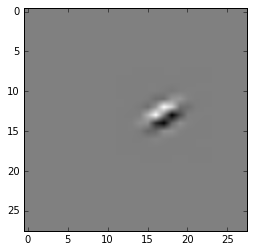

In [6]:
plt.imshow(encoders[0].reshape(28, 28), vmin=encoders[0].min(), vmax=encoders[0].max(), cmap='gray')

In [ ]:
i=[]
j=[]

for theta in range(0,360,6):
    i = np.append(i,round(14 - (np.sin(theta * np.pi /180) * 8.5 + 5.5),3))
    j = np.append(j,round(np.cos(theta * np.pi /180) * 8.5 -5.5 +14,3))
#j = np.cos(0 * np.pi /180) * 8.5 -5.5 +14
#i = 14 - (np.sin(0 * np.pi /180) * 8.5 + 5.5)

print(j)
print(i)

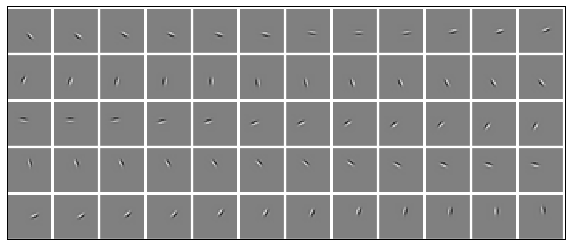

In [7]:
N = 60

import pylab
pylab.figure(figsize=(10,8))
for i in range(N):
    w = i%12
    h = i/12
    pylab.imshow(encoders[i].reshape(28,28), extent=(w, w+0.95, h, h+0.95), interpolation='none',
                 vmin=-1, vmax=1, cmap='gray')
    pylab.xticks([])
    pylab.yticks([])
pylab.xlim((0, 12))
pylab.ylim((0, N/12))
    
pylab.show()

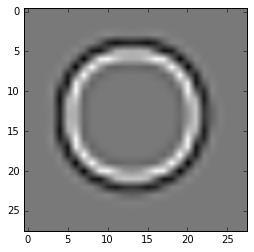

In [9]:
temp = np.sum(all_encoders[:60],axis=0)
temp = np.resize(temp,(28,28))
plt.imshow(temp,cmap='gray')